# CBP Scan

This notebook is used to test the python scripts that will eventually be used, i.e. measure_cbp_data.py, cbp_data_file.py and run_cbp_measurement.py

In [122]:
from astropy.io import fits
import astropy.stats
import numpy as np
import asyncio
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import csv
import yaml
import pandas as pd
import subprocess

from lsst.ts import salobj
from lsst_efd_client import EfdClient, resample
from astropy.time import Time, TimeDelta
from astropy.table import Table

## Configure System

In [123]:
config_file = 'test_config.yaml'

In [129]:
async def Configure(config_file):
    d = open(config_file,'r')
    config = yaml.safe_load(d)
    csc_ = {}
    domain = salobj.Domain()
    include_cscs = config["GENERAL"]["CSC_INCLUDE"]
    
    #Create remote objects
    for csc_name in include_cscs:
        if config[csc_name]['ID'] == 'None':
            csc_[csc_name] = salobj.Remote(name=config[csc_name]['NAME'], domain=domain)
        else:
            csc_[csc_name] = salobj.Remote(name=config[csc_name]['NAME'], domain=domain, index=config[csc_name]['ID']) 
    
    #Start and Enable CSC
    for name, csc in csc_.items():
        try:
            await csc.start_task
            await salobj.set_summary_state(csc, salobj.State.ENABLED, override=config[name]['OVERRIDE'], timeout=20)
        except:
            print("Couldn't enable CSC {}".format(name))

    #Configure Electrometers
    for elec_name in ['SC_ELEC','CBP_ELEC']:
        if elec_name in include_cscs:
            try:
                elec = csc_[elec_name]
                await elec.cmd_setIntegrationTime.set_start(intTime=float(config[elec_name]['INTTIME']))
                await elec.cmd_setMode.set_start(mode=int(config[elec_name]['MODE']))
                await elec.cmd_setRange.set_start(setRange=float(config[elec_name]['RANGE']))
                await elec.cmd_performZeroCalib.set_start(timeout=10)
                await elec.cmd_setDigitalFilter.set_start(activateFilter=False, activateAvgFilter=False, activateMedFilter=False, timeout=10)
            except Exception as e:
                print("Error configuring the electrometer {}".format(elec_name), e)
                
    #Configure Laser
    if 'LASER' in include_cscs:
        try:
            await csc_['LASER'].cmd_changeWavelength.set_start(wavelength=config['LASER']['WAVELENGTH'])
            #Set power and burst? Might be in the config file
        except Exception as e:
            print("Error configuring the laser {}".format(elec_name), e)
        
    #Configure CBP
    if 'CBP' in include_cscs:
        try:
            print('here')
            await csc_['CBP'].cmd_move.set_start(azimuth=float(config['CBP']['AZ']), elevation=float(config['CBP']['ALT']))
            await csc_['CBP'].cmd_setFocus.set_start(focus=float(config['CBP']['FOCUS']))
            await csc_['CBP'].cmd_changeMask.set_start(mask=str(config['CBP']['MASK']))
        except Exception as e:
            print("Error configuring the CBP".format(elec_name), e)
            
    return csc_
    
    

In [130]:
csc_items = await Configure(config_file)

here
Error configuring the CBP msg='Command failed', ackcmd=(ackcmd private_seqNum=725568419, ack=<SalRetCode.CMD_TIMEOUT: -304>, error=1, result='Timeout')


In [131]:
csc_items

{'CBP': <lsst.ts.salobj.remote.Remote at 0x7f436c1b5570>,
 'CBP_ELEC': <lsst.ts.salobj.remote.Remote at 0x7f432970d1e0>,
 'SC_ELEC': <lsst.ts.salobj.remote.Remote at 0x7f432970d2d0>}

## Run Measurement

In [132]:
async def take_elec_measurement(csc_, exp_time, elec_name):
    try:
        tmp = await csc_[elec_name].cmd_startScan.set_start(timeout=10)
        await asyncio.sleep(exp_time)
        tmp = await csc_[elec_name].cmd_stopScan.set_start(timeout=10)
    except Exception as e:
        print('Issue with {} measurement'.format(elec_name), e)
    
async def spect_meas(csc_, exp_time, num_exposures):
    try:
        csc_['SPECTRO'].evt_largeFileObjectAvailable.flush()
        tmp1 = await csc_['SPECTRO'].cmd_expose.set_start(duration=exp_time, numExposures=num_exposures)
    except Exception as e:
        print('Issue with SPECTRO measurement', e)


In [133]:
async def TakeData(csc_, config_file):
    d = open(config_file,'r')
    config = yaml.safe_load(d)
    start_time = Time.now()
    if config['GENERAL']['LIGHT_SOURCE'] == 'LASER':
        await csc_['LASER'].cmd_startPropagateLaser.start()
    
    await asyncio.gather(take_elec_measurement(csc_,config['SC_ELEC']['EXPTIME'], 'SC_ELEC'), 
                          take_elec_measurement(csc_,config['CBP_ELEC']['EXPTIME'], 'CBP_ELEC'), 
                          spect_meas(csc_,config['SPECTRO']['EXPTIME'], config['SPECTRO']['NUM_EXP']))
    
    if config['GENERAL']['LIGHT_SOURCE'] == 'LASER':
        await csc_['LASER'].cmd_stopPropagateLaser.start()
        
    end_time = Time.now()
    return start_time, end_time

In [134]:
start_time, end_time = await TakeData(csc_items, config_file)

Issue with SPECTRO measurement 'SPECTRO'


## Get Data

In [135]:
from lsst_efd_client import EfdClient
client = EfdClient('tucson_teststand_efd')

In [136]:
async def getConfiguration(config_file, csc_items):

    d = open(config_file,'r')
    config = yaml.safe_load(d)
    
#     sys.exit()
#     #Replace as read items for configure items
#     for name, csc in csc_items.items():
#         if name == 'CBP':
#             #get cbp info
#             await csc.evt_inPosition.aget()
#             cbp_target = await csc.evt_target.aget()
            
#     #get laser info
    
#     #get cbp_elec info
#         if name == 'CBP_ELEC':
#             await csc.evt_integrationTime.aget()
#             await csc.evt_measureRange.aget()
#             await csc.evt_measureType.aget()
#             await csc.evt_digitalFilterChange.aget()
            
    
#     #get sc_elec info
#         if name == 'SC_ELEC':
#             await csc.evt_integrationTime.aget()
#             await csc.evt_measureRange.aget()
#             await csc.evt_measureType.aget()
#             await csc.evt_digitalFilterChange.aget()
    
    #get spectro info
    
    
    as_run_config = {}
    for hdr, keys in config.items():
        for name, val in keys.items():
            as_run_config['{}_{}'.format(hdr.lower(),name.lower())] = val
    return as_run_config

In [137]:
def transfer_file(filen, dir_):
    bashCommand = "scp saluser@toonie.tu.lsst.org:/home/saluser/develop/electrometerFitsFiles/{} {}/".format(filen, dir_)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()    
    
async def get_elec_data(start_time, end_time, elec_name, config):
    # Electrometer Data
    start_log_topic = 'lsst.sal.Electrometer.command_startScan'
    start_df =  await client.select_time_series(start_log_topic, ['salIndex'], start=start_time, end=end_time)
    start_df['message'] = 'startScan Completed'
    start_df['functionName'] = 'do_startScan'
    msg_log_topic = 'lsst.sal.Electrometer.logevent_logMessage'
    msg_df = await client.select_time_series(msg_log_topic,['salIndex','functionName','message'], start=start_time, end=end_time)
    elec_df = pd.concat([start_df, msg_df])
    elec_df.sort_index(inplace=True)
    elec_df = pd.concat([start_df, msg_df])
    elec_df.sort_index(inplace=True)
    
    data = []
    e_id = config['{}_id'.format(elec_name.lower())]
    scans = elec_df[elec_df.salIndex == e_id]
    #print(scans)
    scans.reset_index(inplace=True)
    df = pd.DataFrame()
    if len(scans) > 0:
        for i, row in scans.iterrows():
            if (row['functionName'] == 'write_fits_file') & ('Electrometer Scan' in row['message']):
                try:
                    file_row = scans.iloc[i]
                    filen = file_row['message'].split(' ')[-1]
                    transfer_file(filen, os.path.join(config['general_data_dir'],'electrometer_files'))
                    start_meas, end_meas = os.path.splitext(filen)[0].split('_')
                    ff = os.path.join(os.path.join(config['general_data_dir'],'electrometer_files'), filen)
                    edata = fits.open(ff)[0].data
                    values = edata[1]
                    time_delta = edata[0]
                    meas_time = [Time(t + float(start_meas) - 37, scale='tai',format='unix_tai') for t in time_delta]
                    times = [x.datetime64 for x in meas_time]
                    df['values'] = values
                    df['time_delta'] = time_delta
                    df['meas_time'] = pd.to_datetime(times).astype(str)
                    
                    summary_row = scans.iloc[i+1]
                    if 'Scan Summary' in summary_row['message']:
                        x = summary_row['message']
                        x = x.split(':')[1].split(',')
                        mean_ = float(x[0].strip(' ').strip('['))
                        median_ = float(x[1].strip(' '))
                        std_ = float(x[2].strip(' ').strip(']'))

                except:
                    filen, mean_, median_, std_ = np.nan, np.nan, np.nan, np.nan
                    print('error')
                    
        #df = pd.DataFrame(np.array(data), columns=['Amps','time_delta','meas_time'])
        config['{}_filen'.format(elec_name)] = filen
        config['{}_mean'.format(elec_name)] = mean_
        config['{}_median'.format(elec_name)] = median_
        config['{}_std'.format(elec_name)] = std_
        return df, config

        
async def get_spectro_data(start_time, end_time, config):
    try:
        spectro_dir = os.path.join(config['general_data_dir'],'fiberSpec_files')
        spectro_log_topic = 'lsst.sal.FiberSpectrograph.logevent_largeFileObjectAvailable'
        spectro_df =  await client.select_time_series(spectro_log_topic, ['salIndex','url'], start=start_time, end=end_time)
        this_spectro_df = spectro_df[spectro_df['salIndex'] == config['spectro_id']]
        spectra = []
        for i, url in enumerate(this_spectro_df['url']):
            filename=lfa.url.split('FiberSpectrograph')[-1]
            config['SPECTRO_FILE_{}'.format(i)] = filename
            fs_file = os.path.join(spectro_dir, f)
            os.system('curl {} --output {}'.format(url, fs_file))
            hdu = fits.open(fs_file)
            wave = hdu[1].data['wavelength'][0].flatten()
            spectra.append(hdu[0].data)
        waves = np.array(wave, dtype=[('Wavelength', '<f8')])
        return spectra, waves
    except Exception as e:
        print('Issue with SPECTRO data collection', e)
        return None, None
    

In [138]:
as_run_config = await getConfiguration(config_file, csc_items)

if 'CBP_ELEC' in as_run_config['general_csc_include']:
    cbp_elec_df, as_run_config = await get_elec_data(start_time, end_time, 'CBP_ELEC', as_run_config)
if 'SC_ELEC' in as_run_config['general_csc_include']:
    sc_elec_df, as_run_config = await get_elec_data(start_time, end_time, 'SC_ELEC', as_run_config)
if 'SPECTRO' in as_run_config['general_csc_include']:
    spectra, waves = await get_spectro_data(start_time, end_time, as_run_config)

## Save Data

In [139]:
hdulist = fits.HDUList()

hdr = fits.Header()
for key, val in as_run_config.items():
    try:
        hdr[key.upper()] = val
    except:
        print(key)

empty_primary = fits.PrimaryHDU(header=hdr)
hdulist.append(empty_primary)
if 'CBP_ELEC' in as_run_config['general_csc_include']:
    cbp_table = Table.from_pandas(cbp_elec_df)
    hdulist.append(fits.BinTableHDU(cbp_table.as_array(), name='CBP_ELEC'))
if 'SC_ELEC' in as_run_config['general_csc_include']:
    sc_table = Table.from_pandas(sc_elec_df)
    hdulist.append(fits.BinTableHDU(sc_table.as_array(), name='SC_ELEC'))
if 'SPECTRO' in as_run_config['general_csc_include']:
    spectro_table = Table(np.array(spectra))
    hdulist.append(fits.BinTableHDU(spectro_table.as_array(), name='SPECTRO'))
    hdulist.append(fits.BinTableHDU(waves.as_array(), name='WAVELENGTH'))

#Save file
test_name = as_run_config['general_test_name']
save_filen = '{}/{}_{}.fits'.format(os.path.join(as_run_config['general_data_dir'],'CBP_data'), test_name, Time.now().isot)
hdulist.writeto(save_filen, overwrite=True)
print('Data Saved to {}'.format(save_filen))

general_csc_include


Data Saved to /home/parfa30/DATA/CBP_data/code_test_2022-10-18T22:06:35.027.fits


In [140]:
hdu = fits.open(save_filen)

In [141]:
hdu.info()

Filename: /home/parfa30/DATA/CBP_data/code_test_2022-10-18T22:06:35.027.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  CBP_ELEC      1 BinTableHDU     15   9R x 3C   [D, D, 29A]   
  2  SC_ELEC       1 BinTableHDU     15   9R x 3C   [D, D, 29A]   


In [142]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
HIERARCH GENERAL_TEST_NAME = 'code_test'                                        
HIERARCH GENERAL_DATA_DIR = '/home/parfa30/DATA/'                               
HIERARCH GENERAL_LIGHT_SOURCE = 'LED     '                                      
HIERARCH GENERAL_DISTANCE = 2000                                                
CBP_AZ  =                    5                                                  
CBP_ALT =                    0                                                  
HIERARCH CBP_FOCUS = 50                                                         
CBP_MASK=                    3                                                  
HIERARCH CBP_PINHOLE = '5mm 

In [143]:
hdu['CBP_ELEC'].data

FITS_rec([(-2.e-12, 0.      , '2022-10-18 22:06:18.834373474'),
          (-4.e-12, 0.09953 , '2022-10-18 22:06:18.933903456'),
          (-2.e-12, 0.199542, '2022-10-18 22:06:19.033915520'),
          ( 5.e-12, 0.299604, '2022-10-18 22:06:19.133977413'),
          ( 1.e-12, 0.399644, '2022-10-18 22:06:19.234017372'),
          ( 5.e-12, 0.499669, '2022-10-18 22:06:19.334042549'),
          ( 3.e-12, 0.59974 , '2022-10-18 22:06:19.434113503'),
          (-4.e-12, 0.699776, '2022-10-18 22:06:19.534149408'),
          (-2.e-12, 0.799796, '2022-10-18 22:06:19.634169579')],
         dtype=(numpy.record, [('values', '>f8'), ('time_delta', '>f8'), ('meas_time', 'S29')]))

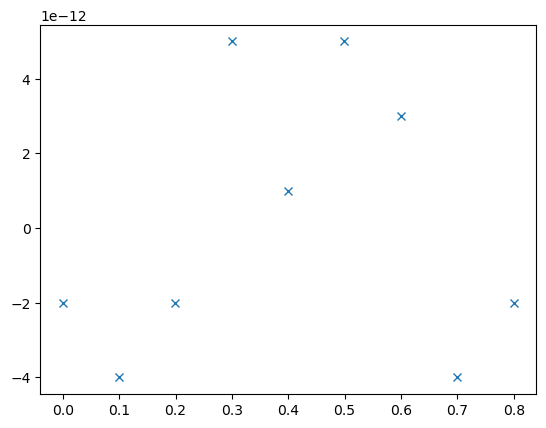

In [145]:
plt.plot(hdu['CBP_ELEC'].data['time_delta'], hdu['CBP_ELEC'].data['values'],'x')

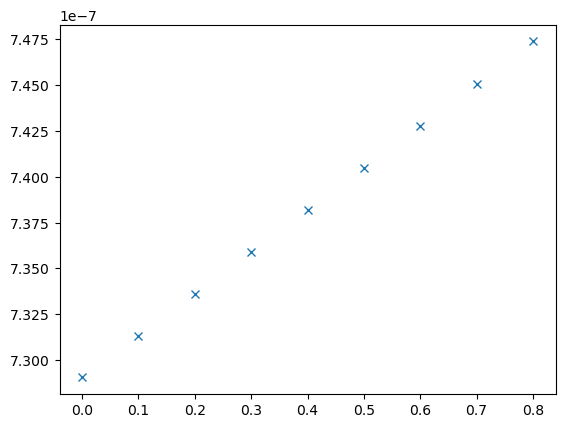

In [146]:
plt.plot(hdu['SC_ELEC'].data['time_delta'], hdu['SC_ELEC'].data['values'],'x')